# Deconvolution for human lymph nodes

## Data preprocessing

In [ ]:
import stSCI
import scanpy as sc
import pandas as pd

sc_adata = sc.read('data/lymph/scRNA.h5ad')
st_adata = sc.read('data/lymph/ST.h5ad')

sc.pp.highly_variable_genes(sc_adata, flavor='seurat_v3', n_top_genes=3000)
sc.pp.highly_variable_genes(st_adata, flavor='seurat_v3', n_top_genes=3000)
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.normalize_total(st_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)
sc.pp.log1p(st_adata)

## Model training

For deconvolution, set the `deconvolution` parameter to `True` to generate the deconvolution result. The deconvolution result will save at `st_adata.obsm['decon_result']`.

In [2]:
sc_adata, st_adata = stSCI.train(sc_adata, st_adata, cluster_key='cell_type', deconvolution=True)

>>> INFO: Filtered 1687 genes.
>>> INFO: Find 1313 same HVGs, result data shapes: [(73260, 1313), (4035, 1313)].
>>> INFO: Generate 28245 edges, 6.000 edges per spot (0.01s).
>>> INFO: Finish PCA (5.07s).
>>> INFO: Finish centroid generation (5.60s).
>>> INFO: Finish centroid generation (0.09s).


>>> Train stSCI: 100%|██████████| 500/500 [02:01<00:00,  4.12it/s]


>>> INFO: Generate 175107 MNN pairs, 2.390 pairs per SC cell; 43.397 pairs per ST spot (2.61s).
>>> INFO: Finish generate deconvolution result (0.33s).
>>> INFO: Train stSCI model (147.09s).


## Evaluation

We assess the alignment of cell type proportions for the three sub-types of B cell germinal centers (GC) cells within the manually annotated GC region.

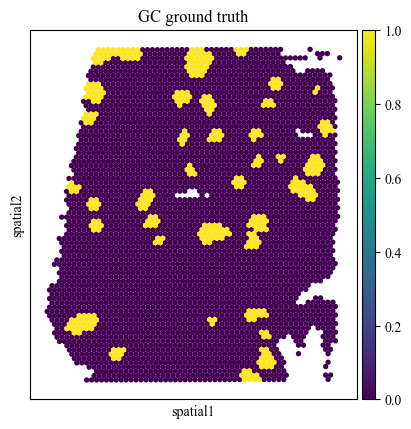

>>> Predicted deconvolution result


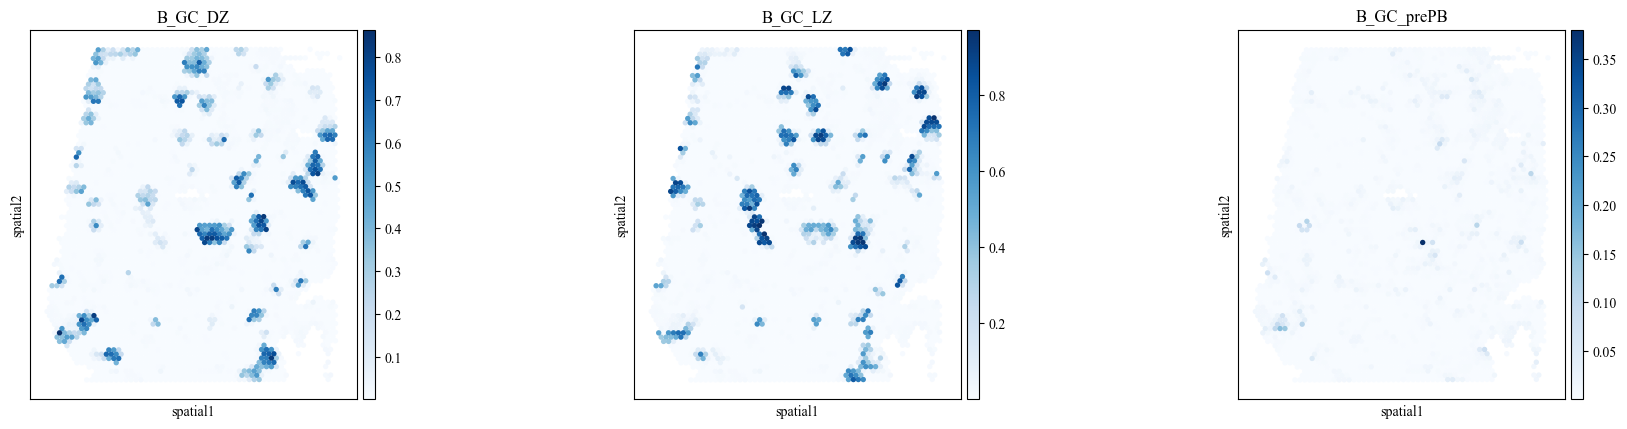

In [3]:
from stSCI.utils.plot import plot_deconvolution

gc_truth = pd.read_csv('../mapping_script/data/data/lymph/manual_GC_annot.csv', index_col=0)
st_adata.obs['gc_label'] = gc_truth['cell_type'].to_numpy()
show_keys = ['B_GC_DZ', 'B_GC_LZ', 'B_GC_prePB']

sc.pl.spatial(st_adata, color='gc_label', title=['GC ground truth'], img_key=None, spot_size=150)
plot_deconvolution(st_adata, spot_size=150, show_keys=show_keys)